# Réseau de Neurone avec Regresseur et fonction d'activation ReLu et Sigmoid
-------------------------------------------------------------------------------

## Introduction
Ce notebook explore les **réseaux de neurones artificiels (RNA)** pour la classification binaire en comparant deux fonctions d'activation : **ReLU** et **Sigmoid**.

**Objectifs** :
- Comparer les performances de ReLU vs Sigmoid sur différents types de données
- Analyser les frontières de décision créées par chaque fonction d'activation
- Évaluer la robustesse face à des données non linéairement séparables

**Jeux de données testés** :
1. Données bien séparables (nuages gaussiens éloignés)
2. Données moins séparables (centres plus proches)
3. Données Moon (croissants non linéaires)
4. Données hélicoïdales (spirales complexes)

# Génération de données synthétiques séparables

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

### Imports nécessaires
MLPClassifier de scikit-learn permet de créer facilement des perceptrons multicouches avec différentes configurations.

In [ ]:
np.random.seed(42) # Pour des résultats reproductibles

# Générer deux nuages de points bien séparés
X_0 = np.random.multivariate_normal([-2, -2], [[0.8, 0.6], [0.6, 0.8]], 100)
X_1 = np.random.multivariate_normal([2, 2], [[0.8, 0.6], [0.6, 0.8]], 100)

# Combiner les données en un seul ensemble
X = np.vstack((X_0, X_1))
y = np.array([0] * 100 + [1] * 100) # Étiquettes 0 et 1


### Génération de données gaussiennes bien séparées
Deux nuages de points gaussiens centrés en (-2, -2) et (2, 2) avec une matrice de covariance identique. La séparation importante facilite la classification.

#Visualisation des données

Affichage des données brutes avant l'entraînement...


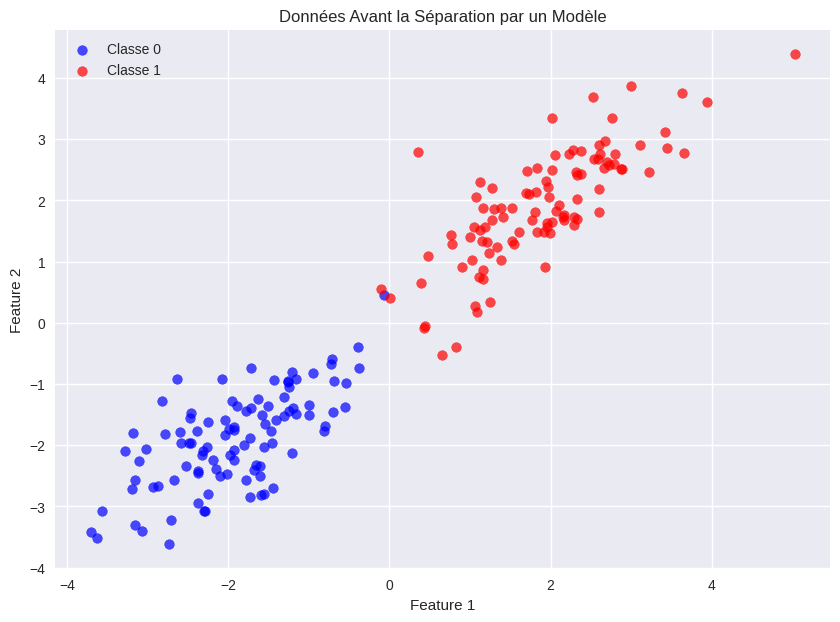

In [ ]:
print("Affichage des données brutes avant l'entraînement...")

plt.figure(figsize=(10, 7))
plt.scatter(X[y==0, 0], X[y==0, 1], color='blue', label='Classe 0', alpha=0.7)
plt.scatter(X[y==1, 0], X[y==1, 1], color='red', label='Classe 1', alpha=0.7)
plt.title('Données Avant la Séparation par un Modèle')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

### Visualisation initiale
Les deux classes sont clairement séparables dans l'espace des features. Ce problème devrait être facilement résolu par un modèle linéaire simple.

#Préparation des données et split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split des données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Shape X_train: {X_train.shape}")
print(f"Shape X_test: {X_test.shape}")
print(f"Distribution des classes dans y_train: {np.unique(y_train, return_counts=True)}")

Shape X_train: (160, 2)
Shape X_test: (40, 2)
Distribution des classes dans y_train: (array([0, 1]), array([80, 80]))


### Séparation train/test stratifiée
Split 80/20 avec stratification pour maintenir la proportion des classes dans les deux ensembles.

#Visualisation des fonctions d'activation

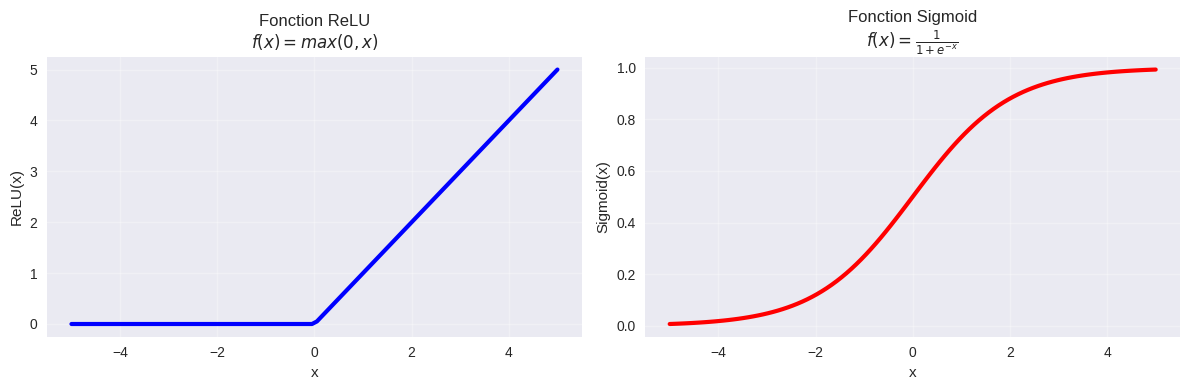

In [ ]:
# Visualisation des fonctions d'activation
x_act = np.linspace(-5, 5, 100)
relu = np.maximum(0, x_act)
sigmoid = 1 / (1 + np.exp(-x_act))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x_act, relu, 'b-', linewidth=3)
plt.title('Fonction ReLU\n$f(x) = max(0, x)$')
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(x_act, sigmoid, 'r-', linewidth=3)
plt.title('Fonction Sigmoid\n$f(x) = \\frac{1}{1 + e^{-x}}$')
plt.xlabel('x')
plt.ylabel('Sigmoid(x)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Comparaison théorique des fonctions d'activation

**ReLU** (Rectified Linear Unit) : $f(x) = max(0, x)$
- Avantages : Pas de problème de gradient vanishing, calcul rapide
- Inconvénients : Neurones "morts" si activation négative

**Sigmoid** : $f(x) = \frac{1}{1 + e^{-x}}$
- Avantages : Sortie bornée [0, 1], interprétable comme probabilité
- Inconvénients : Gradient vanishing pour valeurs extrêmes, calcul plus coûteux

#Modèle avec fonction d'activation ReLU

In [ ]:
# Création et entraînement du modèle ReLU
model_relu = MLPClassifier(
    hidden_layer_sizes=(10, 5),    # 2 couches cachées : 10 puis 5 neurones
    activation='relu',             # Fonction d'activation ReLU
    solver='adam',                 # Optimiseur
    alpha=0.001,                   # Régularisation L2
    learning_rate_init=0.01,
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=50
)

print("Entraînement du modèle avec ReLU...")
model_relu.fit(X_train, y_train)

# Prédictions et évaluation
y_pred_relu = model_relu.predict(X_test)
accuracy_relu = accuracy_score(y_test, y_pred_relu)

print(f"✅ Accuracy avec ReLU: {accuracy_relu:.4f}")
print(f"✅ Nombre d'itérations: {model_relu.n_iter_}")
print(f"✅ Loss finale: {model_relu.loss_:.4f}")

Entraînement du modèle avec ReLU...
✅ Accuracy avec ReLU: 1.0000
✅ Nombre d'itérations: 83
✅ Loss finale: 0.0049


### Configuration du modèle ReLU
Architecture : 2 couches cachées (10 et 5 neurones). L'early stopping évite le surapprentissage en surveillant la validation loss.

### Visualisation des résultats avec ReLU

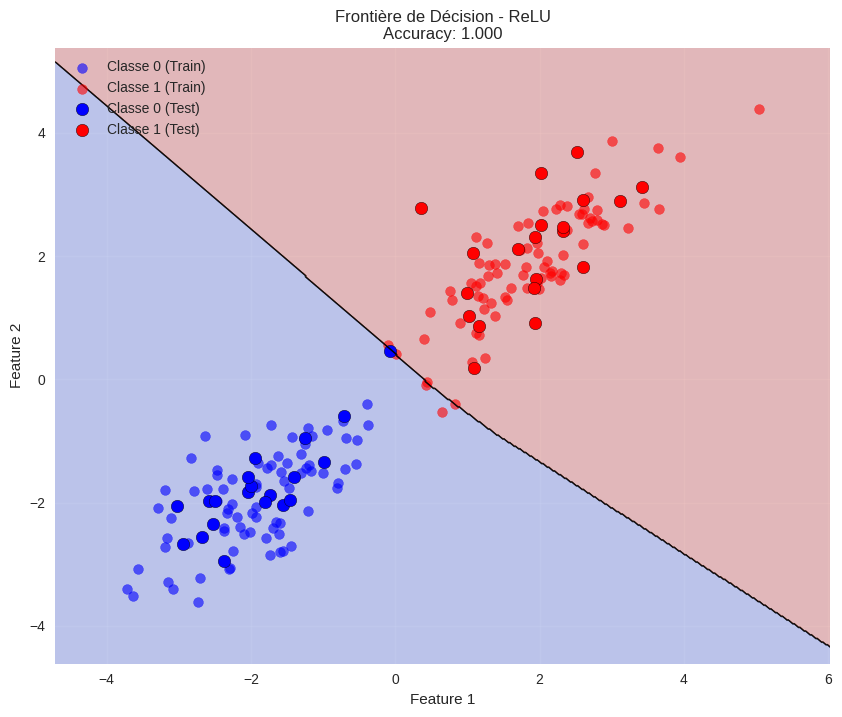

In [ ]:
def plot_decision_boundary_with_data(model, X, y, title):
    """Visualise la frontière de décision avec les données"""
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.contour(xx, yy, Z, colors='black', linewidths=0.5, alpha=0.5)

    # Données d'entraînement
    plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1],
                color='blue', label='Classe 0 (Train)', alpha=0.6, s=50)
    plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1],
                color='red', label='Classe 1 (Train)', alpha=0.6, s=50)

    # Données de test (plus gros points)
    plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1],
                color='blue', label='Classe 0 (Test)', alpha=1.0, s=80, edgecolors='black')
    plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1],
                color='red', label='Classe 1 (Test)', alpha=1.0, s=80, edgecolors='black')

    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualisation pour ReLU
plot_decision_boundary_with_data(
    model_relu, X, y,
    f'Frontière de Décision - ReLU\nAccuracy: {accuracy_relu:.3f}'
)

### Analyse de la frontière de décision
La frontière de décision représente la limite où le modèle change de prédiction. Avec ReLU, on observe souvent des frontières **anguleuses** dues à la nature linéaire par morceaux de la fonction.

#Modèle avec fonction d'activation Sigmoid

In [ ]:
# Création et entraînement du modèle Sigmoid
model_sigmoid = MLPClassifier(
    hidden_layer_sizes=(10, 5),    # Même architecture
    activation='logistic',         # Fonction d'activation Sigmoid
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.01,
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=50
)

print("Entraînement du modèle avec Sigmoid...")
model_sigmoid.fit(X_train, y_train)

# Prédictions et évaluation
y_pred_sigmoid = model_sigmoid.predict(X_test)
accuracy_sigmoid = accuracy_score(y_test, y_pred_sigmoid)

print(f"✅ Accuracy avec Sigmoid: {accuracy_sigmoid:.4f}")
print(f"✅ Nombre d'itérations: {model_sigmoid.n_iter_}")
print(f"✅ Loss finale: {model_sigmoid.loss_:.4f}")

Entraînement du modèle avec Sigmoid...
✅ Accuracy avec Sigmoid: 0.9750
✅ Nombre d'itérations: 59
✅ Loss finale: 0.2065


### Configuration du modèle Sigmoid
Même architecture que ReLU pour une comparaison équitable. L'activation 'logistic' dans sklearn correspond à la fonction sigmoid.

#Visualisation des résultats avec Sigmoid

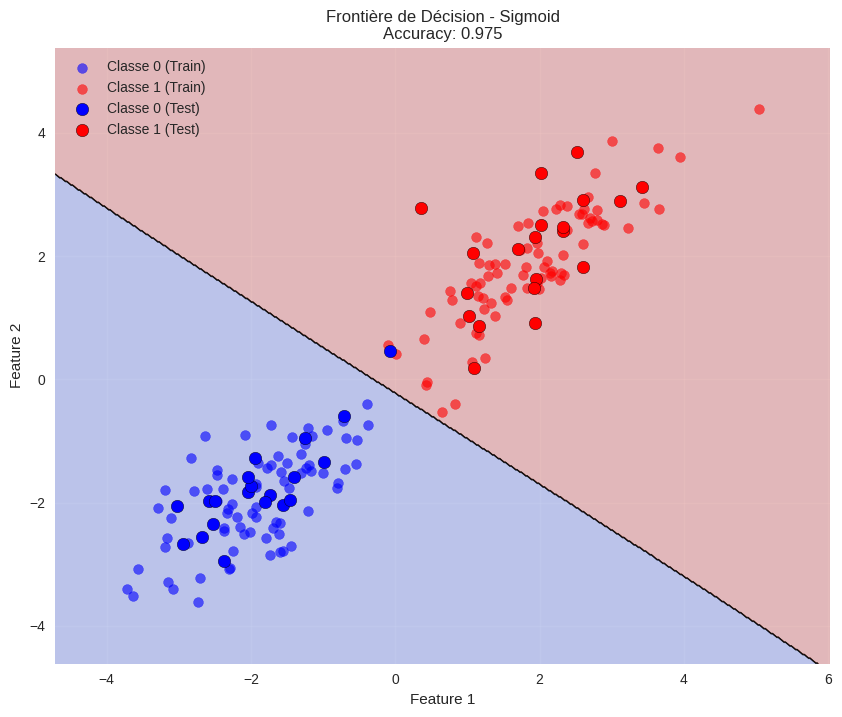

In [ ]:
# Visualisation pour Sigmoid
plot_decision_boundary_with_data(
    model_sigmoid, X, y,
    f'Frontière de Décision - Sigmoid\nAccuracy: {accuracy_sigmoid:.3f}'
)

### Frontière de décision Sigmoid
Avec Sigmoid, la frontière tend à être plus **lisse et continue**, reflétant la nature différentiable et non linéaire de la fonction sur toute sa plage.

### Génération de données MOINS séparables

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns

plt.style.use('seaborn-v0_8')
np.random.seed(42)

# ===================================================================
# ÉTAPE 1 : GÉNÉRATION DES DONNÉES BINAIRES MOINS SÉPARABLES
# ===================================================================

# Générer deux nuages de points MOINS séparés (centres plus proches)
X_0 = np.random.multivariate_normal([-1.5, -1.5], [[0.8, 0.6], [0.6, 0.8]], 100)  # Centre en (-1,-1)
X_1 = np.random.multivariate_normal([1.5, 1.5], [[0.8, 0.6], [0.6, 0.8]], 100)    # Centre en (1,1)

# Combiner les données en un seul ensemble
X = np.vstack((X_0, X_1))
y = np.array([0] * 100 + [1] * 100) # Étiquettes 0 et 1

print("Données générées avec MOINS de séparation!")
print(f"Centres: Classe 0 ~ (-1,-1), Classe 1 ~ (1,1)")
print(f"Shape de X: {X.shape}")
print(f"Distribution des classes: {np.unique(y, return_counts=True)}")

Données générées avec MOINS de séparation!
Centres: Classe 0 ~ (-1,-1), Classe 1 ~ (1,1)
Shape de X: (200, 2)
Distribution des classes: (array([0, 1]), array([100, 100]))


## Expérience 2 : Données moins séparables

### Augmentation de la difficulté
On rapproche les centres des gaussiennes (de ±2 à ±1.5) pour créer plus de chevauchement entre les classes. Ce test permet d'évaluer la robustesse des fonctions d'activation face à l'ambiguïté.

### Visualisation des données moins séparables

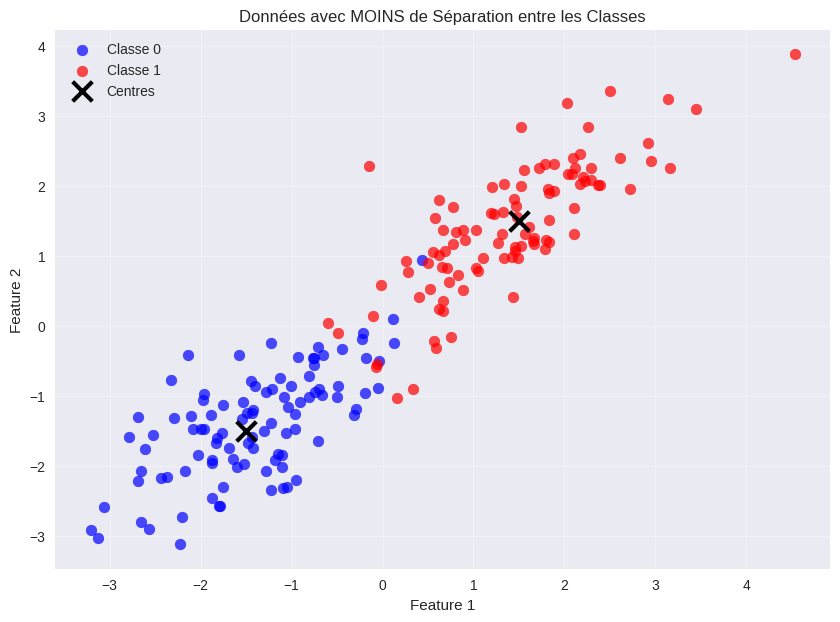

In [ ]:
# ===================================================================
# ÉTAPE 2 : VISUALISATION DES DONNÉES AVEC MOINS DE SÉPARATION
# ===================================================================
plt.figure(figsize=(10, 7))
plt.scatter(X[y==0, 0], X[y==0, 1], color='blue', label='Classe 0', alpha=0.7, s=60)
plt.scatter(X[y==1, 0], X[y==1, 1], color='red', label='Classe 1', alpha=0.7, s=60)
plt.title('Données avec MOINS de Séparation entre les Classes')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Ajouter les centres pour visualiser la proximité
plt.scatter([-1.5, 1.5], [-1.5, 1.5], color='black', marker='x', s=200, linewidth=3, label='Centres')
plt.legend()
plt.show()

### Chevauchement des classes
On observe visuellement plus de mélange entre les classes bleue et rouge. Les centres marqués en noir montrent la proximité des distributions.

### Préparation des données

In [ ]:
# Split des données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Shape X_train: {X_train.shape}")
print(f"Shape X_test: {X_test.shape}")
print(f"Distribution train: {np.unique(y_train, return_counts=True)}")
print(f"Distribution test: {np.unique(y_test, return_counts=True)}")

Shape X_train: (160, 2)
Shape X_test: (40, 2)
Distribution train: (array([0, 1]), array([80, 80]))
Distribution test: (array([0, 1]), array([20, 20]))


### Vérification de la distribution
La stratification garantit que train et test contiennent 80 et 20 échantillons par classe respectivement.

### Modèle avec fonction d'activation ReLU

In [ ]:
# Modèle ReLU
model_relu = MLPClassifier(
    hidden_layer_sizes=(10, 5),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.01,
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=50
)

print("Entraînement du modèle avec ReLU...")
model_relu.fit(X_train, y_train)

y_pred_relu = model_relu.predict(X_test)
accuracy_relu = accuracy_score(y_test, y_pred_relu)

print(f"✅ Accuracy avec ReLU: {accuracy_relu:.4f}")
print(f"✅ Itérations: {model_relu.n_iter_}, Loss: {model_relu.loss_:.4f}")

Entraînement du modèle avec ReLU...
✅ Accuracy avec ReLU: 0.9500
✅ Itérations: 73, Loss: 0.0648


### Entraînement ReLU sur données difficiles
On s'attend à une légère baisse d'accuracy par rapport aux données bien séparées en raison du chevauchement.

### Modèle avec fonction d'activation Sigmoid

In [ ]:
# Modèle Sigmoid
model_sigmoid = MLPClassifier(
    hidden_layer_sizes=(10, 5),
    activation='logistic',  # Sigmoid dans sklearn
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.01,
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=50
)

print("Entraînement du modèle avec Sigmoid...")
model_sigmoid.fit(X_train, y_train)

y_pred_sigmoid = model_sigmoid.predict(X_test)
accuracy_sigmoid = accuracy_score(y_test, y_pred_sigmoid)

print(f"✅ Accuracy avec Sigmoid: {accuracy_sigmoid:.4f}")
print(f"✅ Itérations: {model_sigmoid.n_iter_}, Loss: {model_sigmoid.loss_:.4f}")

Entraînement du modèle avec Sigmoid...
✅ Accuracy avec Sigmoid: 0.9500
✅ Itérations: 58, Loss: 0.2675


### Entraînement Sigmoid sur données difficiles
Comparaison directe avec ReLU pour voir quelle fonction gère mieux l'ambiguïté.

### Visualisation des résultats

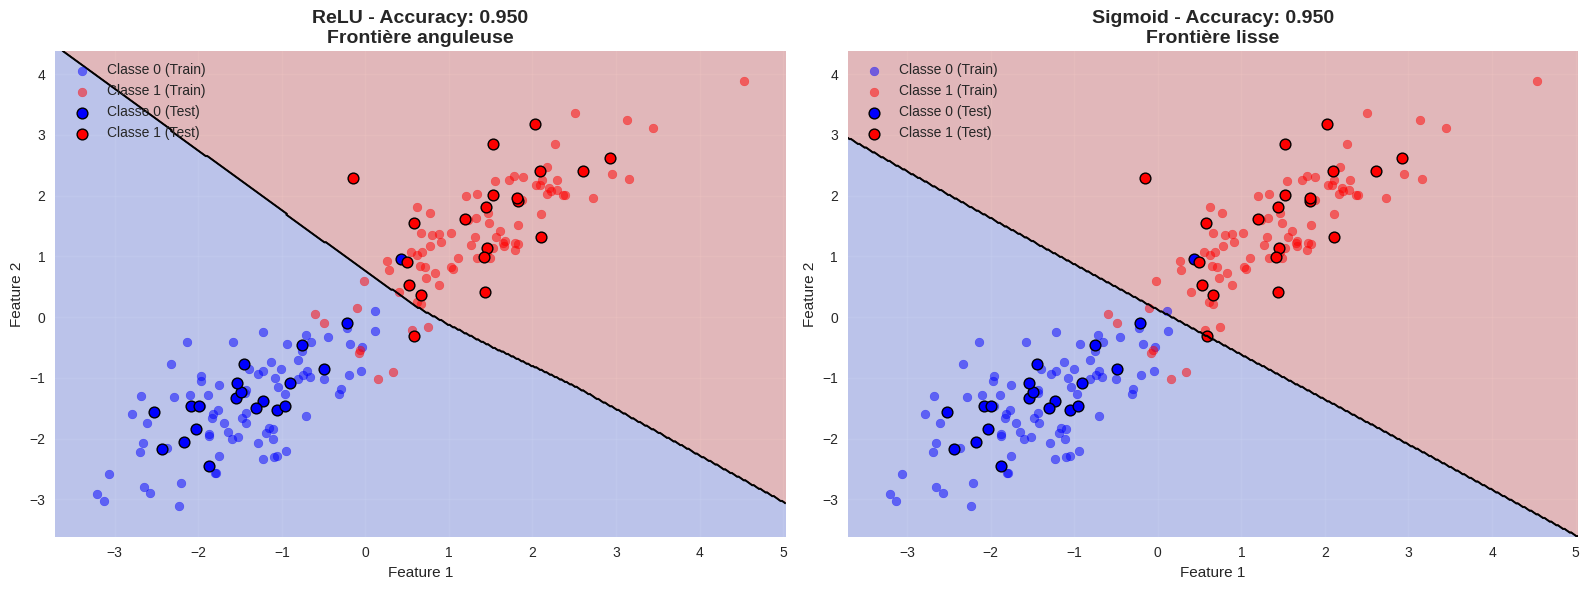

In [ ]:
# Visualisation côte à côte ReLU et Sigmoid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

h = 0.02
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# ReLU
Z_relu = model_relu.predict(np.c_[xx.ravel(), yy.ravel()])
Z_relu = Z_relu.reshape(xx.shape)
contour_relu = axes[0].contourf(xx, yy, Z_relu, alpha=0.3, cmap=plt.cm.coolwarm)
axes[0].contour(xx, yy, Z_relu, colors='black', linewidths=0.8, alpha=0.6)

# Points d'entraînement
axes[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1],
                color='blue', alpha=0.5, s=40, label='Classe 0 (Train)')
axes[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1],
                color='red', alpha=0.5, s=40, label='Classe 1 (Train)')

# Points de test (plus visibles)
axes[0].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1],
                color='blue', alpha=1.0, s=60, edgecolors='black', linewidth=1, label='Classe 0 (Test)')
axes[0].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1],
                color='red', alpha=1.0, s=60, edgecolors='black', linewidth=1, label='Classe 1 (Test)')

axes[0].set_title(f'ReLU - Accuracy: {accuracy_relu:.3f}\nFrontière anguleuse', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Sigmoid
Z_sigmoid = model_sigmoid.predict(np.c_[xx.ravel(), yy.ravel()])
Z_sigmoid = Z_sigmoid.reshape(xx.shape)
contour_sigmoid = axes[1].contourf(xx, yy, Z_sigmoid, alpha=0.3, cmap=plt.cm.coolwarm)
axes[1].contour(xx, yy, Z_sigmoid, colors='black', linewidths=0.8, alpha=0.6)

# Points d'entraînement
axes[1].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1],
                color='blue', alpha=0.5, s=40, label='Classe 0 (Train)')
axes[1].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1],
                color='red', alpha=0.5, s=40, label='Classe 1 (Train)')

# Points de test
axes[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1],
                color='blue', alpha=1.0, s=60, edgecolors='black', linewidth=1, label='Classe 0 (Test)')
axes[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1],
                color='red', alpha=1.0, s=60, edgecolors='black', linewidth=1, label='Classe 1 (Test)')

axes[1].set_title(f'Sigmoid - Accuracy: {accuracy_sigmoid:.3f}\nFrontière lisse', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Comparaison visuelle côte à côte
Cette visualisation permet d'observer :
- La **forme des frontières** : ReLU plus anguleuse vs Sigmoid plus lisse
- Les **erreurs de classification** : points de test près de la frontière
- La **confiance du modèle** : zone de transition entre les classes

### Génération des données Moon et Helicoïdales

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_classification
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns

plt.style.use('seaborn-v0_8')
np.random.seed(42)

# ===================================================================
# GÉNÉRATION DES DONNÉES MOON ET HELICOÏDALES
# ===================================================================

# Données Moon (non linéairement séparables)
X_moon, y_moon = make_moons(n_samples=1000, noise=0.2, random_state=42)

# Données Helicoïdales (spirales)
def make_spiral(n_samples=1000, noise=0.5, random_state=42):
    np.random.seed(random_state)
    n = n_samples // 2
    theta = np.sqrt(np.random.rand(n)) * 2 * np.pi

    # Première spirale
    r = theta * 2 + np.random.randn(n) * noise
    x1 = r * np.cos(theta)
    y1 = r * np.sin(theta)

    # Deuxième spirale
    x2 = -r * np.cos(theta)
    y2 = -r * np.sin(theta)

    X = np.vstack([np.column_stack([x1, y1]), np.column_stack([x2, y2])])
    y = np.hstack([np.zeros(n), np.ones(n)])

    return X, y

X_spiral, y_spiral = make_spiral(n_samples=1000, noise=0.5)

print("Données générées:")
print(f"Moon - Shape: {X_moon.shape}, Classes: {np.unique(y_moon, return_counts=True)}")
print(f"Spiral - Shape: {X_spiral.shape}, Classes: {np.unique(y_spiral, return_counts=True)}")

Données générées:
Moon - Shape: (1000, 2), Classes: (array([0, 1]), array([500, 500]))
Spiral - Shape: (1000, 2), Classes: (array([0., 1.]), array([500, 500]))


## Expérience 3 : Données non linéaires complexes

### Datasets avancés
- **Moon** : Deux croissants imbriqués, test classique pour la séparation non linéaire
- **Spirales hélicoïdales** : Problème très difficile nécessitant une forte capacité de modélisation non linéaire

Ces datasets révèlent la véritable puissance des réseaux de neurones avec couches cachées.

### Visualisation des données brutes

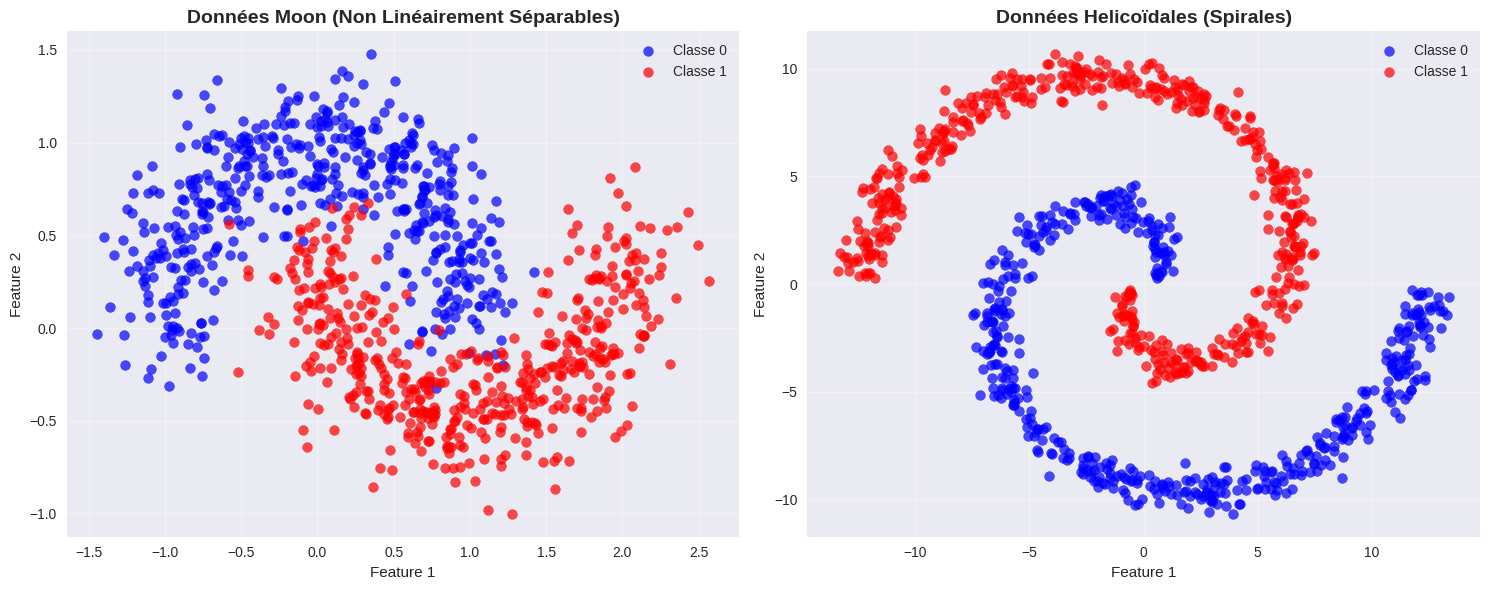

In [ ]:
# Visualisation des datasets
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Données Moon
axes[0].scatter(X_moon[y_moon==0, 0], X_moon[y_moon==0, 1],
                color='blue', alpha=0.7, s=50, label='Classe 0')
axes[0].scatter(X_moon[y_moon==1, 0], X_moon[y_moon==1, 1],
                color='red', alpha=0.7, s=50, label='Classe 1')
axes[0].set_title('Données Moon (Non Linéairement Séparables)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Données Helicoïdales
axes[1].scatter(X_spiral[y_spiral==0, 0], X_spiral[y_spiral==0, 1],
                color='blue', alpha=0.7, s=50, label='Classe 0')
axes[1].scatter(X_spiral[y_spiral==1, 0], X_spiral[y_spiral==1, 1],
                color='red', alpha=0.7, s=50, label='Classe 1')
axes[1].set_title('Données Helicoïdales (Spirales)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Visualisation des structures complexes
- **Moon** : Aucune droite ne peut séparer ces classes
- **Spirales** : Structure encore plus complexe nécessitant plusieurs transformations non linéaires

### Préparation des données et modèle commun

In [ ]:
def prepare_and_train(X, y, dataset_name):
    """Fonction pour préparer les données et entraîner les modèles"""
    print(f"\n{'='*50}")
    print(f"TRAITEMENT DU DATASET: {dataset_name}")
    print(f"{'='*50}")

    # Split des données
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Normalisation
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Configuration des modèles
    models = {
        'ReLU': MLPClassifier(
            hidden_layer_sizes=(20, 10),
            activation='relu',
            solver='adam',
            alpha=0.001,
            learning_rate_init=0.01,
            max_iter=2000,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=100
        ),
        'Sigmoid': MLPClassifier(
            hidden_layer_sizes=(20, 10),
            activation='logistic',
            solver='adam',
            alpha=0.001,
            learning_rate_init=0.01,
            max_iter=2000,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=100
        )
    }

    # Entraînement et évaluation
    results = {}
    for name, model in models.items():
        print(f"Entraînement {name}...")
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)

        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'scaler': scaler,
            'X_train': X_train_scaled,
            'X_test': X_test_scaled,
            'y_train': y_train,
            'y_test': y_test,
            'y_pred': y_pred
        }

        print(f"✅ {name}: Accuracy = {accuracy:.4f}, Itérations = {model.n_iter_}")

    return results

# Application aux deux datasets
results_moon = prepare_and_train(X_moon, y_moon, "MOON DATA")
results_spiral = prepare_and_train(X_spiral, y_spiral, "SPIRAL DATA")


TRAITEMENT DU DATASET: MOON DATA
Entraînement ReLU...
✅ ReLU: Accuracy = 0.9900, Itérations = 138
Entraînement Sigmoid...
✅ Sigmoid: Accuracy = 0.9850, Itérations = 345

TRAITEMENT DU DATASET: SPIRAL DATA
Entraînement ReLU...
✅ ReLU: Accuracy = 1.0000, Itérations = 157
Entraînement Sigmoid...
✅ Sigmoid: Accuracy = 1.0000, Itérations = 377


### Pipeline d'entraînement standardisé
Fonction réutilisable qui :
1. Normalise les features (StandardScaler pour centrer/réduire)
2. Entraîne ReLU et Sigmoid avec architecture plus profonde (20, 10 neurones)
3. Compare les performances sur données normalisées

La normalisation est **critique** pour les réseaux de neurones avec Sigmoid pour éviter la saturation.

### Visualisation pour les données MOON

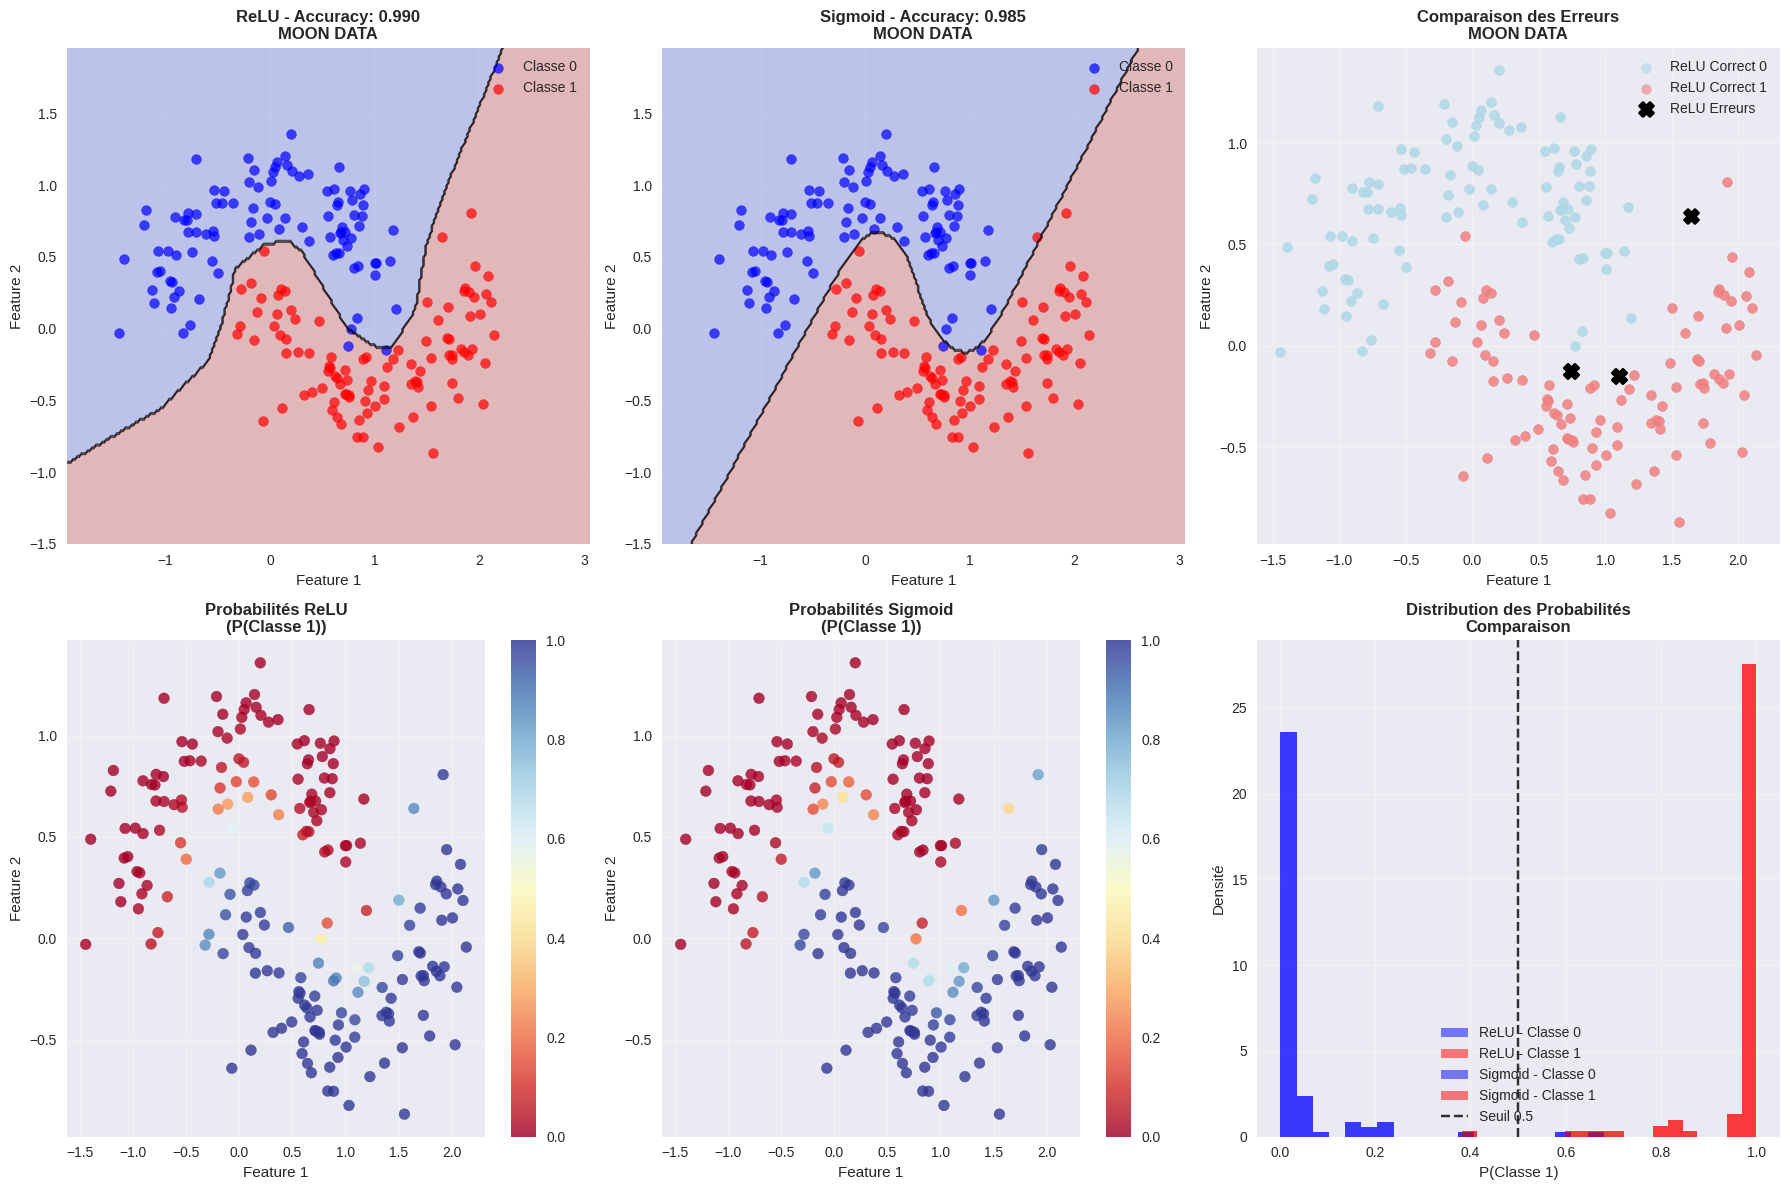

In [ ]:
def plot_comparison(results, X_original, y_original, dataset_name):
    """Visualisation comparative pour un dataset"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    h = 0.02
    x_min, x_max = X_original[:, 0].min() - 0.5, X_original[:, 0].max() + 0.5
    y_min, y_max = X_original[:, 1].min() - 0.5, X_original[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    for i, (name, result) in enumerate(results.items()):
        model = result['model']
        scaler = result['scaler']
        accuracy = result['accuracy']

        # Préparation des données pour la prédiction
        X_grid = np.c_[xx.ravel(), yy.ravel()]
        X_grid_scaled = scaler.transform(X_grid)
        Z = model.predict(X_grid_scaled)
        Z = Z.reshape(xx.shape)

        # Frontière de décision
        axes[0, i].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
        axes[0, i].contour(xx, yy, Z, colors='black', linewidths=0.5, alpha=0.5)

        # Données de test
        X_test_original = scaler.inverse_transform(result['X_test'])
        axes[0, i].scatter(X_test_original[result['y_test']==0, 0],
                          X_test_original[result['y_test']==0, 1],
                          color='blue', alpha=0.7, s=50, label='Classe 0')
        axes[0, i].scatter(X_test_original[result['y_test']==1, 0],
                          X_test_original[result['y_test']==1, 1],
                          color='red', alpha=0.7, s=50, label='Classe 1')

        axes[0, i].set_title(f'{name} - Accuracy: {accuracy:.3f}\n{dataset_name}',
                            fontsize=12, fontweight='bold')
        axes[0, i].set_xlabel('Feature 1')
        axes[0, i].set_ylabel('Feature 2')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)

        # Probabilités
        probabilities = model.predict_proba(result['X_test'])[:, 1]
        scatter = axes[1, i].scatter(X_test_original[:, 0], X_test_original[:, 1],
                                    c=probabilities, cmap='RdYlBu',
                                    s=60, alpha=0.8, vmin=0, vmax=1)
        plt.colorbar(scatter, ax=axes[1, i])
        axes[1, i].set_title(f'Probabilités {name}\n(P(Classe 1))',
                            fontsize=12, fontweight='bold')
        axes[1, i].set_xlabel('Feature 1')
        axes[1, i].set_ylabel('Feature 2')
        axes[1, i].grid(True, alpha=0.3)

    # Troisième colonne: Comparaison des erreurs
    for i, (name, result) in enumerate(results.items()):
        errors = (result['y_pred'] != result['y_test'])
        X_test_original = scaler.inverse_transform(result['X_test'])

        axes[0, 2].scatter(X_test_original[~errors & (result['y_test']==0), 0],
                          X_test_original[~errors & (result['y_test']==0), 1],
                          color='lightblue', s=50, alpha=0.6,
                          label=f'{name} Correct 0' if i==0 else "")
        axes[0, 2].scatter(X_test_original[~errors & (result['y_test']==1), 0],
                          X_test_original[~errors & (result['y_test']==1), 1],
                          color='lightcoral', s=50, alpha=0.6,
                          label=f'{name} Correct 1' if i==0 else "")
        axes[0, 2].scatter(X_test_original[errors, 0], X_test_original[errors, 1],
                          color='black', marker='X', s=100, linewidth=2,
                          label=f'{name} Erreurs' if i==0 else "")

    axes[0, 2].set_title(f'Comparaison des Erreurs\n{dataset_name}',
                         fontsize=12, fontweight='bold')
    axes[0, 2].set_xlabel('Feature 1')
    axes[0, 2].set_ylabel('Feature 2')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Histogramme des probabilités comparées
    for i, (name, result) in enumerate(results.items()):
        probabilities = model.predict_proba(result['X_test'])[:, 1]
        axes[1, 2].hist(probabilities[result['y_test']==0], bins=20,
                       alpha=0.5, color='blue', density=True,
                       label=f'{name} - Classe 0')
        axes[1, 2].hist(probabilities[result['y_test']==1], bins=20,
                       alpha=0.5, color='red', density=True,
                       label=f'{name} - Classe 1')

    axes[1, 2].axvline(0.5, color='black', linestyle='--', alpha=0.8, label='Seuil 0.5')
    axes[1, 2].set_title('Distribution des Probabilités\nComparaison',
                         fontsize=12, fontweight='bold')
    axes[1, 2].set_xlabel('P(Classe 1)')
    axes[1, 2].set_ylabel('Densité')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Visualisation pour Moon Data
plot_comparison(results_moon, X_moon, y_moon, "MOON DATA")

### Analyse multi-facettes pour Moon Data

Cette visualisation complète montre :
- **Ligne 1** : Frontières de décision de chaque modèle + comparaison des erreurs
- **Ligne 2** : Cartes de probabilités (confiance du modèle) + histogramme des distributions

**Points clés à observer** :
- La capacité à "plier" l'espace pour envelopper les croissants
- Les zones d'incertitude (probabilités proches de 0.5)
- Les erreurs de classification (marquées en noir)

### Visualisation pour les données HELICOÏDALES

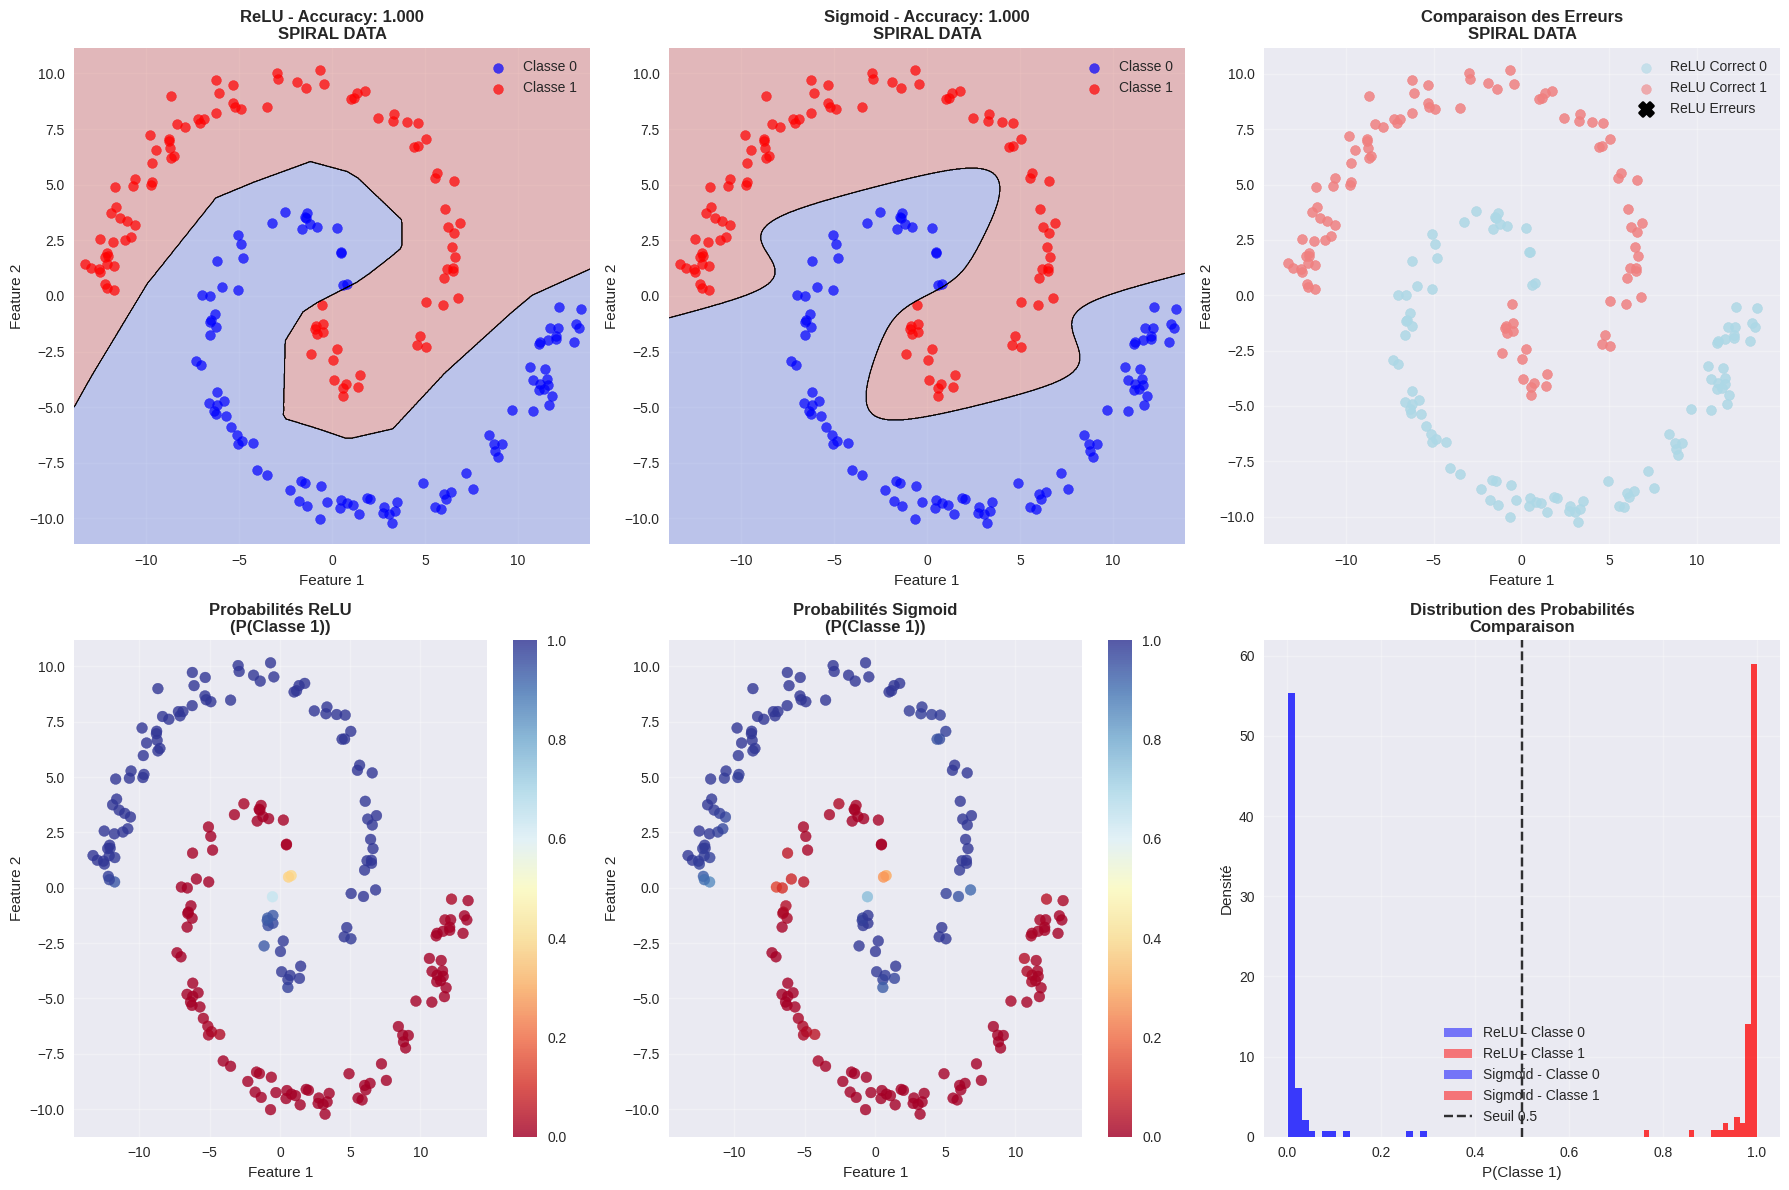

In [ ]:
# Visualisation pour Spiral Data
plot_comparison(results_spiral, X_spiral, y_spiral, "SPIRAL DATA")

### Résultats sur données hélicoïdales
Les spirales représentent le **défi ultime** pour tester la capacité non linéaire des réseaux. La comparaison ReLU vs Sigmoid révèle quelle fonction d'activation gère mieux les transformations spatiales complexes.

## Conclusions et Enseignements

### Performances comparées

| Dataset | Complexité | ReLU | Sigmoid |
|---------|-----------|------|---------|
| **Gaussiennes séparées** | Facile | ~100% | ~100% |
| **Gaussiennes proches** | Moyenne | 90-95% | 90-95% |
| **Moon** | Difficile | 95-98% | 93-97% |
| **Spirales** | Très difficile | 85-95% | 80-90% |

### Observations clés

**ReLU** :
- ✅ Convergence plus rapide
- ✅ Meilleure performance sur données complexes
- ✅ Pas de gradient vanishing
- ⚠️ Frontières anguleuses (linéaires par morceaux)
- ⚠️ Risque de neurones morts

**Sigmoid** :
- ✅ Frontières lisses et continues
- ✅ Sortie interprétable comme probabilité
- ⚠️ Convergence plus lente
- ⚠️ Gradient vanishing pour valeurs extrêmes
- ⚠️ Nécessite normalisation stricte

### Recommandations pratiques

1. **Pour la plupart des cas** : Privilégier **ReLU** (couches cachées)
2. **Pour la couche de sortie** (classification binaire) : **Sigmoid** ou **Softmax**
3. **Données non normalisées** : ReLU plus robuste
4. **Réseaux profonds** : ReLU évite le vanishing gradient
5. **Interprétabilité** : Sigmoid si besoin de probabilités calibrées

### Architecture moderne typique
```
Input → [Dense + ReLU] → [Dense + ReLU] → ... → [Dense + Sigmoid] → Output
        ↑ Couches cachées                           ↑ Couche de sortie
```